# Машинное обучение, ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 30.11.2020 01:00

Мягкий дедлайн: 01:00MSK 14.12.2020

Жесткий дедлайн: 01:00MSK 21.12.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

**Напоминание:**
    
* Все ваши графики должны быть **"красивыми"** --- подробнее о том, как их оформлять, можно найти в первом практическом задании. При несоответствии какиму-то из критериев вам могут снять баллы.
* Пишите в текстовых ячейках/print в коде ответы на **все вопросы из заданий/просьбы сделать выводы** --- при их отсутствии мы не можем понять, сделали ли вы задание и понимаете, что происходит, и поэтому будем снижать баллы

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('figure', dpi=200)
plt.rc('grid', c='grey', ls=':')
plt.rc('font', family='serif')
plt.rc('mathtext', fontset='dejavuserif')

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

In [5]:
X = boston["data"]
y = boston["target"]

In [6]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.20300208554895

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (1.5 баллa)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

<font color=blue>Комментарии к реализации:
* Возникло желание добавить параметр `seed` для воспроизводимости. Преодолеть не получилось. <i>(Сообщение из будущего: дальше в работе при всех случайных генерациях дополнительно вводится сид, по умолчанию равный нулю)</i>
* В формуле для разброса внутри матожидания (по объектам) стоит дисперсия (по выборкам), для оценки которой в условии предлагается усреднять ее по аналогии с матожиданием. Однако по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) для оценки используется исправленная выборочная дисперсия. И именно она считается в реализации, поскольку является несмещенной оценкой дисперсии.
* Перед расчетом смещения, разброса и ошибки необязательно сохранять все предсказания. Так можно было бы сделать, но для этого пришлось бы либо использовать структуры данных нефиксированного размера (например, список списков), либо заранее выделять большой фрагмент памяти, большая часть которого не понадится. В реализации, приведенно ниже, используется другой подход. А именно, для каждого объекта накопливаются три величины: сколько раз он попал в oob (`cnts`), сумма ответов (`sums`), сумма квадратов ответов (`sqr_sums`). Этих статистик достаточно для подсчета общей ошибки, смещения и разброса.
</font>

In [8]:
from tqdm.notebook import trange

def compute_biase_variance(regressor, X, y, num_runs=1000, seed=0):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set of objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    :param seed: int, a seed to initialize random generator
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    rng = np.random.default_rng(seed=seed)
    all_inds = np.arange(len(y))
    sums = np.zeros(len(y), dtype=float)
    sqr_sums = np.zeros_like(sums)
    cnts = np.zeros(len(y), dtype=int)
    for _ in trange(num_runs):
        bs_inds = rng.choice(all_inds, len(y))
        regressor.fit(X[bs_inds], y[bs_inds])
        oob_inds = np.setdiff1d(all_inds, bs_inds)
        preds = regressor.predict(X[oob_inds])
        sums[oob_inds] += preds
        sqr_sums[oob_inds] += preds ** 2
        cnts[oob_inds] += 1
    means = sums[cnts > 0] / cnts[cnts > 0]
    error = (y[cnts > 0] * (y[cnts > 0] - 2 * means)).mean()
    error += (sqr_sums[cnts > 0] / cnts[cnts > 0]).mean()
    bias = ((means - y[cnts > 0]) ** 2).mean()
    variance = ((sqr_sums[cnts > 1] - (sums[cnts > 1] ** 2) / cnts[cnts > 1])
                / (cnts[cnts > 1] - 1)).mean()
    return bias, variance, error

**Задание 2. (0.5 баллa)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


<font color=blue>В параметрах sklearn-реализаций зафиксируем сид.</font>

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

names = ['linear regression', 'decision tree', 'random forest']
models = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=0),
    RandomForestRegressor(random_state=0),
]
results = pd.DataFrame(index=names, columns=['bias', 'variance', 'error', '|bvd - error|'])
for name, model in zip(names, models):
    model.fit(X, y)
    results.loc[name][:-1] = compute_biase_variance(model, X, y)
results.iloc[:, -1] = (results.iloc[:, 0] + results.iloc[:, 1] - results.iloc[:, 2]).abs()

In [10]:
results

,bias,variance,error,|bvd - error|
linear regression,23.7287,0.923713,24.6499,0.00251937
decision tree,10.3007,13.1013,23.3662,0.0357746
random forest,10.6973,2.2294,12.9206,0.00609826


Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__
<font color=blue>Общая оценка ошибки почта совпадает с разложением на смещение и разброс! Различия обусловлены тем, что мы не учитываем шум и вычисляем непараметрические оценки рассматриваемых величин. Результаты вполне согласуются с теорией, которую мы обсуждали на семинарах. Наименьший разброс, как у самого «простого» алгоритма, у линейной регрессии, наибольший — у решающего дерева (об это далее). При этом предсказание линейной регресии оказались сильно смещены, что также характерно для простых моделей.</font>

Вспомните во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__
<font color=blue>В проведенных экспериментах данный факт подтверждается отличием результатов в работе случайного леса и решающего дерева. В последнем варианте усредняются ответы работы деревьев, которые построены на подвыборках, сгенерерированных с помощью бутстрапа (бэггинг — bootstrap aggregation). Результаты показывают, что смещение почти не меняется, а вот разброс случайного леса почти в 6 раз меньше разброса решающего дерева. Согласно теории, при «хорошем» раскладе дисперсия могла бы уменьшится в число раз, соответствующее длине композиции. Дефолтное число деревьев в RandomForest — 100. В нашем эксперименте разброс не уменьшился в 100 раз из-за «не столь хорошего расклада»: алгоритмы одной природы и между ними присутствует корреляция.</font>

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (1.5 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [11]:
from sklearn.model_selection import train_test_split

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", seed=0):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=num_test_objects, random_state=0)
    rng = np.random.default_rng(seed=seed)
    xs = np.arange(num_test_objects)
    for i in range(num_runs):
        bs_inds = rng.choice(len(y_train), len(y_train))
        regressor.fit(X_train[bs_inds], y_train[bs_inds])
        plt.scatter(xs, regressor.predict(X_test), color='magenta', s=90)
    plt.scatter(xs, y_test, color='black', marker='*', s=80)
    plt.title(title)
    plt.xlabel('test object number')
#     plt.ylabel('target')
    plt.xticks(xs)

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

<font color=blue>Выровняем по единой оси ординат, но для наглядности не будем стирать пометки.</font>

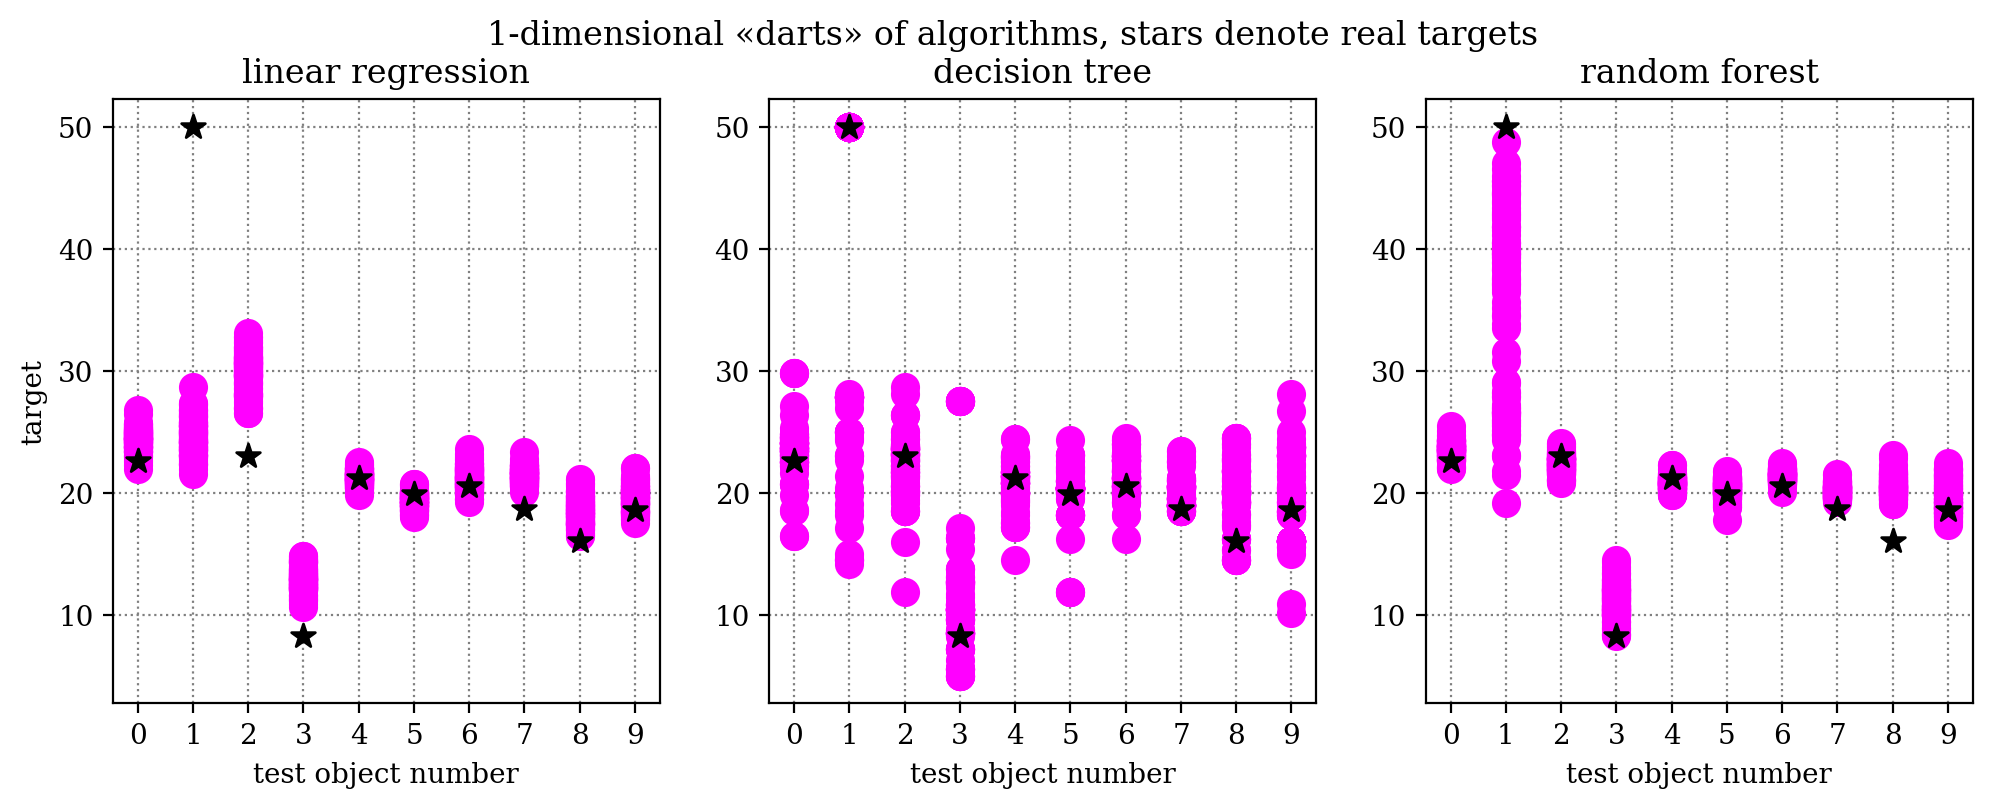

In [12]:
plt.figure(figsize=(12, 4))
for i, (name, model) in enumerate(zip(names, models)):
    if i == 0:
        ax = plt.subplot(1, 3, i + 1)
        plt.ylabel('target')
    else:
        plt.subplot(1, 3, i + 1, sharey=ax)
    plot_predictions(model, X, y, title=name)
plt.suptitle('1-dimensional «darts» of algorithms, stars denote real targets')
plt.show()

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here:**
<font color=blue>Отметим, что по результатам работы алгоритмов видно, что скорее всего 1-й объект является выбросом — его истинная целевая переменная (цена дома) значительно превосходит оставшиеся, и алгоритмы часто ошибаются на нем. В меньшей мере это касается и 3-го объекта (уже в сторону низких цен).</font>
* <font color=blue><b>Линейная регрессия</b> дает предсказания с наименьшим разбросом. Ее «простота», однако, не позволяет ей сделать адекватное предсказание для 1-го объекта, хотя на 3-м ее ответы близки к истине. Той же причиной может быть обусловлена неожиданная ошибка на 2-м объекте (все ответы смещены). Это может быть и следствием переобучения.</font>
* <font color=blue>У <b>решающего дерева</b> действительно самый большой разброс по объектам (за исключением поведения леса на 1-м, но об этом далее). Но зато, в отличие от линейной регрессии, на каждый объект нашлось решающее дерево с достаточно точным предсказанием. А также у данного алгоритма видно наименьшее смещение.</font>
* <font color=blue>Результаты <b>случайного леса</b> получились неоднозначными. Смещение почти всегда меньше, чем в линейной регрессии, но не всегда (объект 8). Разброс, опять же, чаще меньше, чем в линейной регрессии, но не на объектах 2, 3, 5, 9. И на 2-м здесь самый большой разброс в принципе: ответы «размазаны» от среднего к истинному наибольшему. Причем достигнуть истинного значения лесу не вполне удается — усреднение по множествам деревьев приводит к сглаживанию, и здесь ответы часто корректируются в сторону среднего. </font>

<font color=blue>В целом, результаты согласуются с теорией и табличкой, полученной в задании 2.</font>

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869) (вам нужны только данные, посылать туда ничего не надо).
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы:
    * Воспользуйтесь описанием соревнования
    * При желании, воспользуйтесь методами feature selection/стат. методами, если хотите. Объясните, что использовали и почему решили выкинуть тот или иной признак.
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0. Если считаете нужным, сделайте сбалансированное по классам разбиение.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

<font color=blue>Для предотвращения ликов сразу разделим выборку на трейн и тест (сделав <b>сбалансированное по классам разбиение</b>), а затем будем строить преобразование по трейну.</font>

In [13]:
from sklearn.model_selection import train_test_split

features = pd.read_csv('../input/hse19-gbm/application_train.csv', index_col=0)
Y = features.pop('TARGET')

X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.3,
                                                    random_state=0, stratify=Y)

<font color=blue>Описание соревнования ссылается описание другого [соревнования](https://www.kaggle.com/c/home-credit-default-risk/data), в котором есть специальный файл с описанием признаков. Выведем смысл целевой переменной и сохраним информацию об интересующих нас признаках.</font>

In [14]:
import numpy as np

In [15]:
fname = '../input/home-credit-default-risk/HomeCredit_columns_description.csv'
info = pd.read_csv(fname, index_col=0, encoding='ISO-8859-1')

print("What do we need to predict?")
print(info[info['Row'] == 'TARGET']['Description'].iloc[0])

info = info[(info['Table'] == 'application_{train|test}.csv')
            & (info['Row'].isin(X_train.columns))].drop(columns='Table')

What do we need to predict?
Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)


<font color=blue>То есть мы фактически решаем задачу кредитного скоринга.</font>

In [16]:
# check if everything is okay and count features
(info['Row'] == X_train.columns).sum()

120

<font color=blue>Посмотрим на первые признаки (`Row` — названия признаков, `Description` — описание, `Special` — дополнительная информация):</font>

In [17]:
info.head()

,Row,Description,Special
5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,CODE_GENDER,Gender of the client,NaN
7,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
9,CNT_CHILDREN,Number of children the client has,NaN


<font color=blue>У нас 120 признаков — чтобы не выводить гигантскую таблицу, проверим, есть ли повторы (в описаниях):</font>

In [18]:
def df_full_col(df):
    """do not truncate text in DataFrame"""
    with pd.option_context('display.max_colwidth', -1):
        ret_st = df.style
    return ret_st

def nlargest_duplicates(df, col, n=5):
    descr_cnts = df.groupby(col).size().sort_values(ascending=False)[:n]
    res_df = df.loc[df[col].isin(descr_cnts.index)].groupby(col).agg(
                lambda s: set(s)).reindex(descr_cnts.index)
    res_df.insert(0, 'Counts', descr_cnts.values)
    return res_df

In [19]:
popular_descr = nlargest_duplicates(info, 'Description')
df_full_col(popular_descr)

,Counts,Row,Special
Description,,,
"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",47,"{'APARTMENTS_MODE', 'ELEVATORS_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'ENTRANCES_MEDI', 'EMERGENCYSTATE_MODE', 'YEARS_BUILD_MODE', 'LANDAREA_MEDI', 'APARTMENTS_AVG', 'LANDAREA_AVG', 'LANDAREA_MODE', 'FLOORSMIN_AVG', 'LIVINGAREA_MEDI', 'YEARS_BUILD_AVG', 'HOUSETYPE_MODE', 'LIVINGAREA_MODE', 'COMMONAREA_MEDI', 'APARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_MODE', 'COMMONAREA_MODE', 'ENTRANCES_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'TOTALAREA_MODE', 'YEARS_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'NONLIVINGAREA_MODE', 'ENTRANCES_MODE', 'LIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE', 'FLOORSMAX_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_AVG', 'LIVINGAREA_AVG', 'COMMONAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 'NONLIVINGAREA_MEDI', 'FLOORSMIN_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'FLOORSMAX_MEDI', 'WALLSMATERIAL_MODE', 'FLOORSMAX_AVG', 'BASEMENTAREA_MEDI'}",{'normalized'}
Normalized score from external data source,3,"{'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1'}",{'normalized'}
"Did client provide home phone (1=YES, 0=NO)",2,"{'FLAG_WORK_PHONE', 'FLAG_PHONE'}",{nan}
Who was accompanying client when he was applying for the loan,1,{'NAME_TYPE_SUITE'},{nan}
Did client provide document 8,1,{'FLAG_DOCUMENT_8'},{nan}


<font color=blue>Итак, 47 признаков имеет одинаковое описание. Их значения — меры central tendency для различных характеристик дома клиента (нормализованные). В данной группе наверняка многие коррелируют, и пока непонятно, нужно ли такое большое число признаков, относящихся к жилью заемщика. Другие 3 признака с одинаковым описанием — скороинг со сторонних ресурсов. Возможно, они окажутся достаточно сильными. Наконец, еще 2 бинарных признака связаны с (не)предоставлением номера телефона оО.</font>
<font color=blue>Чтобы обнаружить другую большую группу, попробуем убрать из описания цифры:</font>

In [20]:
seen_features = set(popular_descr['Row'].iloc[:3].apply(lambda s: [*s]).sum())
rem_info = info[~info['Row'].isin(seen_features)].copy()
rem_info['Description w/o numbers'] = rem_info['Description'].str.replace('\d+', '')
dwonum = nlargest_duplicates(rem_info, 'Description w/o numbers', 1)
seen_features |= dwonum.iloc[0, 1]
df_full_col(dwonum)

,Counts,Row,Description,Special
Description w/o numbers,,,,
Did client provide document,20,"{'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_14'}","{'Did client provide document 10', 'Did client provide document 11', 'Did client provide document 13', 'Did client provide document 4', 'Did client provide document 17', 'Did client provide document 5', 'Did client provide document 14', 'Did client provide document 8', 'Did client provide document 15', 'Did client provide document 18', 'Did client provide document 21', 'Did client provide document 16', 'Did client provide document 2', 'Did client provide document 7', 'Did client provide document 6', 'Did client provide document 20', 'Did client provide document 9', 'Did client provide document 3', 'Did client provide document 12', 'Did client provide document 19'}",{nan}


<font color=blue>Видим, что 20 признаков отвечают за предоставление определенных документов. Теперь мы готовы вывести таблицу с оставшимися признаками:</font>

In [21]:
rem_info.drop(columns='Description w/o numbers', inplace=True)
df_full_col(rem_info[~rem_info['Row'].isin(dwonum.iloc[0, 1])])

,Row,Description,Special
5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,nan
6,CODE_GENDER,Gender of the client,nan
7,FLAG_OWN_CAR,Flag if the client owns a car,nan
8,FLAG_OWN_REALTY,Flag if client owns a house or flat,nan
9,CNT_CHILDREN,Number of children the client has,nan
10,AMT_INCOME_TOTAL,Income of the client,nan
11,AMT_CREDIT,Credit amount of the loan,nan
12,AMT_ANNUITY,Loan annuity,nan
13,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,nan
14,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,nan


<font color=blue>В последней таблице признаки с номерами:</font>
* <font color=blue>$5, 11-13$ содержат информацию о текущем запросе на предоставление кредита.</font>
* <font color=blue>$7, 8, 10, 15, 24, 43$ соответствуют достаточно вопросам об имуществе и финансах клиента. </font>
* <font color=blue>$6, 9, 14, 16-18, 31, 32$ связаны с личностью и семейном положением человека.</font>
* <font color=blue>$19, 33, 34, 37-42$ относятся к региону, городу, т.е. аггрегируют географическую информацию.</font>
* <font color=blue>$25-30, 98$ содержат некоторые сведения о том, как клиент предоставлял свои контакты оО</font>
* <font color=blue>$20-23$ — счетчики дней с момента некоторых событий в жизни клиента.</font>
* <font color=blue>$94-97$ — информация о невыполнении договора займа со стороны людей из социального окружения клиента.</font>
* <font color=blue>$119-124$ связаны с прошлыми обращениями клиента в кредитное бюро.</font>

<font color=blue>Встречаются признаки бинарные, вещественные, категориальные, а некоторые имеют рейтинговый смысл. Теперь мы имеем представление о смысле признаков, осталось удалить совсем нерелевантные и разобраться с пропусками.</font>

<font color=blue>Определим типы признаков:</font>

In [22]:
def get_dtypes(data):
    gr = data.columns.groupby(data.dtypes)
    return {str(dtype): list(val) for dtype, val in gr.items()}

dtypes = get_dtypes(X_train)
for dtype in dtypes:
    print(f'{dtype}: {dtypes[dtype]}\n')

int64: ['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

float64: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EX

<font color=blue>Сначала удалим некоторые целочисленные признаки. В решении нам поможет их разброс!</font>

In [23]:
drop_features = []

def nan_cnt(X):
    return X.isna().sum()

st = ['var', 'mean', 'nunique', nan_cnt]
var_info = X_train[dtypes['int64']].agg(st).T.sort_values(by='var')
var_info.astype({'nunique': 'int', 'nan_cnt': 'int'})

,var,mean,nunique,nan_cnt
FLAG_MOBIL,0.000000e+00,1.000000,1,0
FLAG_DOCUMENT_12,6.636625e-06,0.000007,2,0
FLAG_DOCUMENT_10,1.327316e-05,0.000013,2,0
FLAG_DOCUMENT_2,2.654597e-05,0.000027,2,0
FLAG_DOCUMENT_4,6.636228e-05,0.000066,2,0
FLAG_DOCUMENT_7,1.924264e-04,0.000192,2,0
FLAG_DOCUMENT_17,2.587631e-04,0.000259,2,0
FLAG_DOCUMENT_21,2.985609e-04,0.000299,2,0
FLAG_DOCUMENT_20,4.842421e-04,0.000484,2,0
FLAG_DOCUMENT_19,6.102007e-04,0.000611,2,0


<font color=blue>Получается, у некоторых признаков вообще отсутствует (или почти отсутствует) какое-либо разнообразие в значениях. В случае малого числа различных значений для построения дерева это будет означать меньший шанс попадения в критерий расщепления — `FLAG_MOBIL` вообще константен (наверное, тяжело взять кредит без предоставления номера телефона), и в обучении он никак не поможет. Очевидно, мы его удаляем. Также мы удалим признаки `FLAG_DOCUMENT_12`, ..., FLAG_DOCUMENT_5, поскольку они отвечают за наличиев документов (которые почти все либо предоставляют, либо не предоставляют), что не является информативным для выдачи кредита, а также FLAG_CONT_MOBILE.</font>

In [24]:
drop_features += list(var_info.loc[:'REG_REGION_NOT_LIVE_REGION'].index)

<font color=blue>Таким образом, мы удалили константные и почти константные целочисленные признаки, по смыслу не являющиеся значимыми для кредитного скоринга. Кстати, в целочисленных признаках не оказалось пропусков.</font>

<font color=blue>А что с вещественными?</font>

In [25]:
float_info = X_train[dtypes['float64']].agg(['mean', nan_cnt]).T
df_full_col(float_info.sort_values('nan_cnt', ascending=False)
            .astype({'nan_cnt': 'int'}))

,mean,nan_cnt
COMMONAREA_MODE,0.042554,105370
COMMONAREA_MEDI,0.044675,105370
COMMONAREA_AVG,0.044744,105370
NONLIVINGAPARTMENTS_MODE,0.008246,104629
NONLIVINGAPARTMENTS_MEDI,0.008849,104629
NONLIVINGAPARTMENTS_AVG,0.009002,104629
LIVINGAPARTMENTS_MODE,0.105664,103029
LIVINGAPARTMENTS_MEDI,0.102026,103029
LIVINGAPARTMENTS_AVG,0.100902,103029
FLOORSMIN_MEDI,0.231721,102286


<font color=blue>Здесь с пропусками все хуже. Очевидно, что некоторые из них сильно коррелированы — и в случае с линейными моделями стоило бы выбрать хотя бы лучший признак в каждой группе. Однако мультиколлинеарность в случае ансамбля деревьев не страшна: расщепление, производимое в вершинах, будет выбирать наилучшие признаки.</font>

<font color=blue>Вернемся к вопросу заполнения пропусков. Поскольку разрешается «произвольная стретегия», то воспользуемся тем, что и CatBoost, и LightGBM умеют (и делают это по умолчанию) обрабатывать пропуски — оставим их сейчас без изменения.</font>

<font color=blue>Мы можем видеть крайне низкое среднее у NONLIVINGAPARTMENTS (т.е. заемщики не часто владеют нежилыми квартирами) и крайне выское число пропусков, что делает группу признаков не особо информативным (но на всякий случай оставим NONLIVINGAREA). Еще крайне много нулей в AMT_REQ_CREDIT_BUREAU_HOUR и AMT_REQ_CREDIT_BUREAU_DAY (действительно, часто ли люди берут кредит ежедневно и уж тем более ежечасно), удалим и их:</font>

In [26]:
drop_features += ['NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG',
                  'NONLIVINGAPARTMENTS_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
                  'AMT_REQ_CREDIT_BUREAU_DAY']

<font color=blue>Осталось разобраться со строками.</font>

In [27]:
st = ['nunique', nan_cnt]
X_train[dtypes['object']].agg(st).T.sort_values('nan_cnt', ascending=False)

,nunique,nan_cnt
FONDKAPREMONT_MODE,4,103091
WALLSMATERIAL_MODE,7,76639
HOUSETYPE_MODE,3,75628
EMERGENCYSTATE_MODE,2,71419
OCCUPATION_TYPE,18,47109
NAME_TYPE_SUITE,7,643
NAME_CONTRACT_TYPE,2,0
CODE_GENDER,3,0
FLAG_OWN_CAR,2,0
FLAG_OWN_REALTY,2,0


<font color=blue>Поскольку впереди нас ждет кодирование, проще сразу заполнить пропуски строкой 'nan'.</font>

In [28]:
X_train.loc[:, dtypes['object']] = X_train.loc[:, dtypes['object']].fillna('nan')
X_test.loc[:, dtypes['object']] = X_test.loc[:, dtypes['object']].fillna('nan')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


<font color=blue>Что касается отбора категориальных признаков, то далее мы будем использовать несколько способов их кодирования и правильлнее было бы оценивать важность уже новых численных признаков. Но чтобы завершить блок отбора признаков, все же попробуем на данном этапе оценить важность непосредственно сырых категорий для предсказания целевой переменной.</font>

<font color=blue>Поскольку <s>я пока не знаю других статистических тестов, которые применимы к данной задаче</s> число категорий в каждом признаке (кроме, может быть `ORGANIZATION_TYPE`) не велико, может быть разумно проверить критерий независимости $\chi^2$ (Пирсона). Кстати, в sklearn'е своеобразная реализация этого теста (т.е. он считает другую статистику: <a href=https://stackoverflow.com/questions/21281328/scikit-learn-%CF%87%C2%B2-chi-squared-statistic-and-corresponding-contingency-table>link1</a>, <a href=https://stackoverflow.com/questions/50932433/scipy-and-sklearn-chi2-implementations-give-different-results>link2</a>, <a href=https://stats.stackexchange.com/questions/315697/%CF%87%C2%B2-chi-squared-statistic-of-scipy-stats-chi2-contingency-vs-sklearn-feature-se>link3</a>), поэтому воспользуемся scipy.</font>

In [29]:
from scipy.stats import chi2_contingency

chi2s = []
ps = []
for cat in dtypes['object']:
    chi2, p, _, _ = chi2_contingency(pd.crosstab(X_train[cat], y_train))
    chi2s.append(chi2)
    ps.append(p)

In [30]:
st = {'$\chi^2$': chi2s, 'p-value': ps}
pd.DataFrame(data=st, index=dtypes['object']).sort_values('$\chi^2$')

,$\chi^2$,p-value
WEEKDAY_APPR_PROCESS_START,11.858025,6.521208e-02
FLAG_OWN_REALTY,12.355045,4.397964e-04
NAME_TYPE_SUITE,25.637753,5.844937e-04
FLAG_OWN_CAR,92.652410,6.233463e-22
FONDKAPREMONT_MODE,140.616874,2.082451e-29
NAME_CONTRACT_TYPE,169.916476,7.716297e-39
NAME_HOUSING_TYPE,209.263077,2.959164e-43
HOUSETYPE_MODE,237.851083,2.774602e-51
EMERGENCYSTATE_MODE,259.118953,5.407970e-57
NAME_FAMILY_STATUS,260.691500,3.235759e-55


<font color=blue>Гипотезу независимости принимаем только для `WEEKDAY_APPR_PROCESS_START` (и исключаем этот столбец). Действительно, здесь записан день недели подачи заявки — вполне предсказуемо, что он не имеет особого смысла для предсказания. А вот следующий за ним `FLAG_OWN_REALTY` уже так смело выкидывать нельзя: тут указано, живет клиент в доме или в квартире, что в процессе построения дерева все-таки может сыграть роль.</font>

In [31]:
drop_features += ['WEEKDAY_APPR_PROCESS_START']

<font color=blue>Ура, мы наконец разобрались с пропусками и отобрали признаки. <i>Более точный/избирательный отбор можно было бы производить с помощью самих моделей бустинга (используя, например, `feature_importance`), тогда параллельно можно за качеством. Также мы не попробовали жадный перебор.</i></font>

In [32]:
print('Raw feature counts:', {dtype: len(dtypes[dtype]) for dtype in dtypes})
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features)
dtypes = get_dtypes(X_train)
print('After feature selection:', {dtype: len(dtypes[dtype]) for dtype in dtypes})

Raw feature counts: {'int64': 39, 'float64': 65, 'object': 16}
After feature selection: {'int64': 19, 'float64': 60, 'object': 15}


<font color=blue>Далее нам будет удобно рассматривать разбиение только на две группы.</font>

In [33]:
num_features = dtypes['int64'] + dtypes['float64']
str_features = dtypes['object']

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Получилась ли заметная разнциа в качестве? Как вы думаете, почему?**

**Замечание:**
* В этом и последующих экспериментах необходимо измерять время обучения моделей.

<font color=blue>Обсуждение в телеграме подтвердило, что общем случае есть проблемы со способом вычисления PR-AUC: у нас неопределенность в начальной точке, а также численно по-разному считаются average_precision_score и auc(recall, precision). Но в случае предсказаний бустинга разница почти отсутствует, и мы будем далее считать функционал с помощью average_precision_score. </font>

In [34]:
from sklearn.metrics import average_precision_score as pr_auc

def learn_predict_auc(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    return pr_auc(y_test, y_proba)

In [35]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

samples = [X_train[num_features], y_train, X_test[num_features], y_test]

<font color=blue>Напомним, что мы везде используем random_state (равный нулю) для воспроизводимости.</font>

In [36]:
%%time
learn_predict_auc(LGBMClassifier(random_state=0), *samples)

CPU times: user 14.6 s, sys: 285 ms, total: 14.8 s
Wall time: 4.06 s


0.2269831522669753

In [37]:
%%time
learn_predict_auc(CatBoostClassifier(random_state=0, verbose=0), *samples)

CPU times: user 3min 30s, sys: 10.9 s, total: 3min 41s
Wall time: 1min 1s


0.2314512745089144

<font color=blue>Разница в качестве не столь заметна, но она есть. Причины разницы в том, что CatBoost нацелен как раз на меньшую чувствительность к настройке гиперпараметров, и ожидаемо видеть у него лучшее качество на данном этапе. К тому же реализации отличаются способом построения деревьев: leaf-wise у LightGBM и depth-wise у CatBoost. Еще мы можем видеть существенные различия во времени работы (обусловленные оптимизациями LightGBM).</font>

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb).

**Проанализируйте соотношения получившихся оптимальных глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

<font color=blue>Вообще говоря, в документации LightGBM к важным признакам относятся также `num_leaves` и `min_data_in_leaf`. Вариант настройки в задании больше относится к росту деревьев depth-wise, что реализовано в CatBoost. Также удобно все параметры перебирать на увеличенном темпе обучения (отчего уменьшатся и необходимое число деревьев). Но тогда нам останется подобрать только глубину. А от оптимизируемого функционала вообще зависит решение. В общем, параетров мало, диапазон значений тоже небольшой, поэтому сделаем полный перебор. В качестве оптимизируемого функционала оставим логлосс, поскольку для других вариантов нужно либо использовать регрессор вместо классификатора, либо передавать кастомную метрику.</font>

In [38]:
from sklearn.model_selection import PredefinedSplit

split = np.where(y_test.index.get_indexer(features.index) < 0, -1, 0)
ps = PredefinedSplit(test_fold=split)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [1, 5, 10, 100, 200, 300, 400, 500, 600, 700],
}

In [39]:
from sklearn.model_selection import GridSearchCV

clf = LGBMClassifier(random_state=0)
gs = GridSearchCV(clf, param_grid, scoring='average_precision', cv=ps)
gs.fit(features[num_features], Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1,  0, ..., -1,  0])),
             estimator=LGBMClassifier(random_state=0),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [1, 5, 10, 100, 200, 300, 400, 500,
                                          600, 700]},
             scoring='average_precision')

In [40]:
def print_gs_info(gs):
    print('Best parameters:', gs.best_params_)
    print('Best PR-AUC:', gs.best_score_)
    times = gs.cv_results_['mean_fit_time']
    print(f'Fit time of the best estimator: {times[gs.best_index_]:.2f} s')
    print(f'Mean fit time: {times.mean():.2f} s')
    print(f'Total fit time in grid search: {times.sum():.2f} s')

In [41]:
print_gs_info(gs)

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400}
Best PR-AUC: 0.2355643566917928
Fit time of the best estimator: 9.80 s
Mean fit time: 7.61 s
Total fit time in grid search: 1521.92 s


In [42]:
clf = CatBoostClassifier(verbose=0, random_state=0)
gs = GridSearchCV(clf, param_grid, scoring='average_precision', cv=ps)
gs.fit(features[num_features], Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1,  0, ..., -1,  0])),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f5b27572710>,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [1, 5, 10, 100, 200, 300, 400, 500,
                                          600, 700]},
             scoring='average_precision')

In [43]:
print_gs_info(gs)

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 400}
Best PR-AUC: 0.2384497560211465
Fit time of the best estimator: 18.55 s
Mean fit time: 15.15 s
Total fit time in grid search: 3030.46 s


**Your answer here:**
* <font color=blue>В обоих случаях удалось улучшить качество на дефолтных параметрах, причем относительные результаты остались стабильными: у CatBoost лучшая метрика, а у LightGBM — скорость.</font>
* <font color=blue>Соотношения получившихся оптимальных глубины и числа деревьев совпало для обоих алгоритмов! Это вызвано нашим дизайном эксперимента (выбором настраиваемых параметров и их диапазона), при учете особенностей каждой из реализаций бустинга итоговые результаты вышли бы разными. Тем не менее получившаяся глубина — 4 — хоть и относится к средним вариантам, такие деревья обычно считаются неглубокими. Интересно, что с небольшой глубиной обычно требуется большее число деревьев, однако у нас оптимальным вышло среднее числов диапазоне. Темп обучения 0.1, оптимальный в CatBoost, считается достаточно агрессивным, но вполне приемлем при таком числе деревьев, а в LightGBM оптимальным оказался чуть меньший, 0.05. Отметим, что все полученные гиперпараметры не являются граничными в исследуемом пространстве.</font>

**Задание 7 (1.5 баллa)**

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

<font color=blue>Воспользуемся библиотечными реализациями <a href='http://contrib.scikit-learn.org/category_encoders/'>Category Encoders</a>. Ради интереса замерим и время предобработки.</font>

In [44]:
import category_encoders as ce

ohe_enc = ce.one_hot.OneHotEncoder(cols=str_features)
%timeit -r1 -n1 ohe_enc.fit(X_train)
X_train_ohe = ohe_enc.transform(X_train)
X_test_ohe = ohe_enc.transform(X_test)

smoothed_cnt_enc = ce.target_encoder.TargetEncoder(cols=str_features,
                                                   smoothing=1)
%timeit -r1 -n1 smoothed_cnt_enc.fit(X_train, y_train)
X_train_cnt = smoothed_cnt_enc.transform(X_train)
X_test_cnt = smoothed_cnt_enc.transform(X_test)

enc_names = ['no categorical', 'one-hot', 'smoothed counts']
enc_trains = [X_train[num_features], X_train_ohe, X_train_cnt]
enc_tests = [X_test[num_features], X_test_ohe, X_test_cnt]

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


5.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


1.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<font color=blue>На самом деле для one-hot гораздо быстрее работает get_dummies (из Pandas), но его неудобно применять из-за отсутствия явной обработки ситуаций, когда в тесте появляются новые категории или пропадают старые. Warning'и некритичны, связаны с обновлением интерфейса Pandas.</font>

In [45]:
lgbm_params = {
    'random_state': 0,
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 400
}

cb_params = {
    'random_state': 0,
    'verbose': 0,
    'learning_rate': 0.1,
    'max_depth': 4,
    'n_estimators': 400
}

clfs = {
    'LightGBM': LGBMClassifier(**lgbm_params),
    'CatBoost': CatBoostClassifier(**cb_params),
}

<font color=blue>Каждую комбинацию запустим 3 раза и усредним время (секунды).</font>

In [46]:
res_idx = pd.MultiIndex.from_product([clfs.keys(), ['time', 'PR-AUC']])
results = pd.DataFrame(index=res_idx, columns=enc_names)

for clf_name in clfs:
    for enc_name, Xtr, Xts in zip(enc_names, enc_trains, enc_tests):
        fit_time = %timeit -r3 -n1 -o -q clfs[clf_name].fit(Xtr, y_train)
        results.loc[(clf_name, 'time'), enc_name] = round(np.mean(fit_time.timings), 2)
        score = pr_auc(y_test, clfs[clf_name].predict_proba(Xts)[:, 1])
        results.loc[(clf_name, 'PR-AUC'), enc_name] = score

In [47]:
results

no categorical   one-hot smoothed counts
LightGBM time              8.9     11.08           10.52
         PR-AUC       0.235564  0.237361        0.240463
CatBoost time            18.03     19.58           19.33
         PR-AUC       0.237463  0.240453        0.242491

<font color=blue>Во-первых снова подчеркнем крутость счетчиков: они дают лучшее качество и работают быстрее one-hot кодирования. При включении категориальных признаков обоими способами, время обучения увеличивается, разница при one-hot более выражена из-за расширения признакового пространства (в соответствии с общим числом категорий). Но разница во времени не столь существенна из-за не очень уж и большого признакового пространства для градиентного бустинга даже при one-hot:</font>

In [48]:
[tr.shape[1] for tr in enc_trains]

[79, 217, 94]

**Задание 8 (1 балл)**

Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта).  Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [49]:
%timeit -r3 -n1 clfs['CatBoost'].fit(X_train, y_train, cat_features=str_features)
pr_auc(y_test, clfs['CatBoost'].predict_proba(X_test)[:, 1])

1min 7s ± 192 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


0.24167154059163654

<font color=blue>Время увеличилось, неужели документация нас <a href='https://catboost.ai/docs/features/categorical-features.html'>обманула</a>?! Ну, во-первых, CatBoost даже по умолчанию реализует не совсем тривиальную обработку категориальных признаков: при дефолтном one-hot, например, в нем используется малое число значений, и, возможно, алгоритмы предобработки CatBoost оказываются быстрее при большем объеме данных (или на других наборах гиперпараметров). А во-вторых, качество получилось лучше, чем при предварительном one-hot кодировании. (Хотя и меньше, чем при использовании сглаженного счетчика).</font>

**Бонус. (1 балл)**

Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

**Бонус (0.2 балла)**

Вставьте лучший мем 2020

<font color=blue>Извините, но будет два!</font>

<img src='https://i.ibb.co/6DDXMGR/strad2.jpg' width='400'>

<img src='https://i.ibb.co/VQtZHNM/stradaniyeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee.jpg' width="600">